<a href="https://colab.research.google.com/github/itayko2/titanic/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
plt.style.use('seaborn')
np.random.seed(seed=42)

In [ ]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

In [ ]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

In [3]:
train_url = 'https://raw.githubusercontent.com/itayko2/titanic/main/train.csv'
test_url = 'https://raw.githubusercontent.com/itayko2/titanic/main/test.csv'
train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)

# Exploratory Data Analysis (EDA)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [6]:
train_data.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

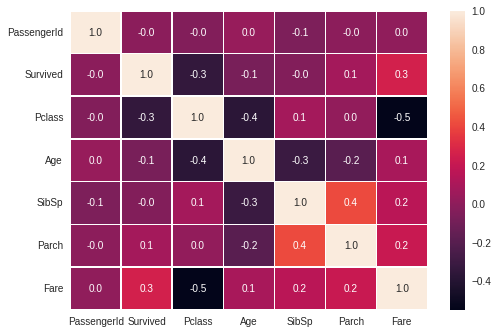

In [7]:
# Correlation with target value
corrMatrix = train_data.corr()
f,ax = plt.subplots()
sns.heatmap(corrMatrix, annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

# Data pre-processing

In [8]:
train_data['IsTrain'] = 1
test_data['IsTrain'] = 0

In [9]:
# Concat train & test to get better idea of how to fill missing vals
test_data[['Survived']] = np.NaN
df1 = pd.concat([train_data, test_data])
df1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsTrain
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


Get cabin letter which stands for the deck on the ship

In [10]:
df2 = pd.DataFrame().assign(Cabin=df1['Cabin'])
df2['CabinLetter'] = np.nan
df2

,Cabin,CabinLetter
0,NaN,NaN
1,C85,NaN
2,NaN,NaN
3,C123,NaN
4,NaN,NaN
...,...,...
413,NaN,NaN
414,C105,NaN
415,NaN,NaN
416,NaN,NaN


In [11]:
df2.loc[(df2.Cabin.str.match('^A.*')==True),'CabinLetter']=1
df2.loc[(df2.Cabin.str.match('^B.*')==True),'CabinLetter']=2
df2.loc[(df2.Cabin.str.match('^C.*')==True),'CabinLetter']=3
df2.loc[(df2.Cabin.str.match('^D.*')==True),'CabinLetter']=4
df2.loc[(df2.Cabin.str.match('^E.*')==True),'CabinLetter']=5
df2.loc[(df2.Cabin.str.match('^F.*')==True),'CabinLetter']=6
df2.loc[(df2.Cabin.str.match('^G.*')==True),'CabinLetter']=7
print(df2[df2.CabinLetter == np.nan].sum())
df2.head()

Cabin          0.0
CabinLetter    0.0
dtype: float64


,Cabin,CabinLetter
0,NaN,NaN
1,C85,3.0
2,NaN,NaN
3,C123,3.0
4,NaN,NaN


Get passengers nationality and native language by their name, guessed that english passengers will have better surviving rates because they can understand the crew instructions.

In [12]:
df3 = pd.DataFrame().assign(Name=df1['Name'])
df3

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
...,...
413,"Spector, Mr. Woolf"
414,"Oliva y Ocana, Dona. Fermina"
415,"Saether, Mr. Simon Sivertsen"
416,"Ware, Mr. Frederick"


In [13]:
last_name_df = df3['Name'].str.split(" ", n = -1, expand = True)
df3['LastName']= last_name_df[0]
df3['FirstName']= last_name_df[2]

df3['LastName'] = df3['LastName'].str.replace(',','')

df3.head()

,Name,LastName,FirstName
0,"Braund, Mr. Owen Harris",Braund,Owen
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,John
2,"Heikkinen, Miss. Laina",Heikkinen,Laina
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Jacques
4,"Allen, Mr. William Henry",Allen,William


using ethnicolr module to predict nationalities by names

In [ ]:
! pip install ethnicolr

In [14]:
from ethnicolr import pred_wiki_name

df3 = pred_wiki_name(df3, 'LastName', 'FirstName')
df3.head()

['Asian,GreaterEastAsian,EastAsian', 'Asian,GreaterEastAsian,Japanese', 'Asian,IndianSubContinent', 'GreaterAfrican,Africans', 'GreaterAfrican,Muslim', 'GreaterEuropean,British', 'GreaterEuropean,EastEuropean', 'GreaterEuropean,Jewish', 'GreaterEuropean,WestEuropean,French', 'GreaterEuropean,WestEuropean,Germanic', 'GreaterEuropean,WestEuropean,Hispanic', 'GreaterEuropean,WestEuropean,Italian', 'GreaterEuropean,WestEuropean,Nordic']


,Name,LastName,FirstName,__name,rowindex,"Asian,GreaterEastAsian,EastAsian_mean","Asian,GreaterEastAsian,EastAsian_std","Asian,GreaterEastAsian,EastAsian_lb","Asian,GreaterEastAsian,EastAsian_ub","Asian,GreaterEastAsian,Japanese_mean","Asian,GreaterEastAsian,Japanese_std","Asian,GreaterEastAsian,Japanese_lb","Asian,GreaterEastAsian,Japanese_ub","Asian,IndianSubContinent_mean","Asian,IndianSubContinent_std","Asian,IndianSubContinent_lb","Asian,IndianSubContinent_ub","GreaterAfrican,Africans_mean","GreaterAfrican,Africans_std","GreaterAfrican,Africans_lb","GreaterAfrican,Africans_ub","GreaterAfrican,Muslim_mean","GreaterAfrican,Muslim_std","GreaterAfrican,Muslim_lb","GreaterAfrican,Muslim_ub","GreaterEuropean,British_mean","GreaterEuropean,British_std","GreaterEuropean,British_lb","GreaterEuropean,British_ub","GreaterEuropean,EastEuropean_mean","GreaterEuropean,EastEuropean_std","GreaterEuropean,EastEuropean_lb","GreaterEuropean,EastEuropean_ub","GreaterEuropean,Jewish_mean","GreaterEuropean,Jewish_std","GreaterEuropean,Jewish_lb","GreaterEuropean,Jewish_ub","GreaterEuropean,WestEuropean,French_mean","GreaterEuropean,WestEuropean,French_std","GreaterEuropean,WestEuropean,French_lb","GreaterEuropean,WestEuropean,French_ub","GreaterEuropean,WestEuropean,Germanic_mean","GreaterEuropean,WestEuropean,Germanic_std","GreaterEuropean,WestEuropean,Germanic_lb","GreaterEuropean,WestEuropean,Germanic_ub","GreaterEuropean,WestEuropean,Hispanic_mean","GreaterEuropean,WestEuropean,Hispanic_std","GreaterEuropean,WestEuropean,Hispanic_lb","GreaterEuropean,WestEuropean,Hispanic_ub","GreaterEuropean,WestEuropean,Italian_mean","GreaterEuropean,WestEuropean,Italian_std","GreaterEuropean,WestEuropean,Italian_lb","GreaterEuropean,WestEuropean,Italian_ub","GreaterEuropean,WestEuropean,Nordic_mean","GreaterEuropean,WestEuropean,Nordic_std","GreaterEuropean,WestEuropean,Nordic_lb","GreaterEuropean,WestEuropean,Nordic_ub",race
0,"Braund, Mr. Owen Harris",Braund,Owen,Braund Owen,0,0.016112,0.017658,0.000673,0.000997,0.045787,0.036822,0.007662,0.008263,0.003229,0.003645,0.000280,0.000308,0.013365,0.011802,0.000705,0.001108,0.005383,0.005495,0.000457,0.000486,0.760079,0.086119,0.544338,0.550195,0.002967,0.002401,0.000433,0.000493,0.037234,0.019649,0.010132,0.010974,0.022738,0.013358,0.005205,0.005774,0.007479,0.006738,0.001457,0.001490,0.006556,0.005295,0.000700,0.000915,0.041257,0.027532,0.005357,0.007305,0.037815,0.037148,0.002823,0.003915,"GreaterEuropean,British"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,John,Cumings John,1,0.004123,0.002535,0.001047,0.001112,0.001884,0.001385,0.000258,0.000385,0.002474,0.002144,0.000589,0.000613,0.000662,0.001961,0.000077,0.000094,0.000368,0.000430,0.000032,0.000040,0.955268,0.020951,0.839338,0.849877,0.000610,0.000724,0.000097,0.000124,0.006217,0.003549,0.001961,0.002394,0.015693,0.005810,0.006591,0.006649,0.002549,0.002736,0.000495,0.000509,0.003443,0.002404,0.000928,0.000936,0.004901,0.004016,0.001038,0.001074,0.001809,0.002131,0.000236,0.000305,"GreaterEuropean,British"
2,"Heikkinen, Miss. Laina",Heikkinen,Laina,Heikkinen Laina,2,0.002087,0.002079,0.000059,0.000213,0.008235,0.008182,0.000408,0.001166,0.002532,0.003071,0.000119,0.000134,0.005004,0.005879,0.000239,0.000305,0.012768,0.018755,0.001515,0.002040,0.051191,0.026367,0.006581,0.009725,0.091189,0.060133,0.015646,0.017362,0.410791,0.235729,0.017994,0.030598,0.021270,0.011320,0.001904,0.003129,0.207386,0.125130,0.016916,0.017511,0.032322,0.026408,0.001824,0.002981,0.010335,0.008452,0.000465,0.000549,0.144889,0.168725,0.001751,0.002838,"GreaterEuropean,Jewish"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Jacques,Futrelle Jacques,3,0.000282,0.000227,0.000024,0.000027,0.000252,0.000380,0.000017,0.000020,0.000403,0.000501,0.000007,0.000018,0.000971,0.001168,0.000062,0.000095,0.000094,0.000102,0.000003,0.000005,0.048473,0.056879,0.004374,0.004499,0.000524,0.000627,0.000033,0.000043,0.026178,0.032875,0.001101,0.001142,0.908897,0.09244

In [24]:
df4 = pd.DataFrame().assign(Race=df3['race'])

In [25]:
df4.head()

,Race
0,"GreaterEuropean,British"
1,"GreaterEuropean,British"
2,"GreaterEuropean,Jewish"
3,"GreaterEuropean,WestEuropean,French"
4,"GreaterEuropean,British"


# Remove features and fill missing values

In [26]:
df1['Age'].fillna(df1['Age'].median(), inplace = True)

df1['Embarked'].fillna(df1['Embarked'].mode()[0], inplace = True)

df1['Fare'].fillna(df1['Fare'].median(), inplace = True)

In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
 12  IsTrain      1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.2+ KB


In [36]:
final_df = df1[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','IsTrain']]

In [ ]:
final_df['Nationality'] = df4['Race']
final_df['CabinLetter'] = df2['CabinLetter']

In [ ]:
final_df.loc[final_df.CabinLetter.isna(),'CabinLetter'] = 0

In [42]:
final_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsTrain,Nationality,CabinLetter
0,0.0,3,male,22.0,1,0,7.2500,S,1,"GreaterEuropean,British",0.0
1,1.0,1,female,38.0,1,0,71.2833,C,1,"GreaterEuropean,British",3.0
2,1.0,3,female,26.0,0,0,7.9250,S,1,"GreaterEuropean,Jewish",0.0
3,1.0,1,female,35.0,1,0,53.1000,S,1,"GreaterEuropean,WestEuropean,French",3.0
4,0.0,3,male,35.0,0,0,8.0500,S,1,"GreaterEuropean,British",0.0


In [33]:
# One hot encoding to change all non - numeric/boolean categorical data
def preprocess(df):

  df_processed = df
  categorical_columns = ['Sex', 'Embarked','Nationality']
  for cname in categorical_columns:
    dummies = pd.get_dummies(df_processed[cname], prefix=cname)
    df_processed = pd.concat([df_processed, dummies], axis=1)
    df_processed.drop([cname], axis=1, inplace=True)

  return df_processed

In [ ]:
processed_df = preprocess(final_df)
processed_df.head()

In [ ]:
df_train=processed_df[processed_df.IsTrain==1]
df_train.head()

In [ ]:
df_test=processed_df[processed_df.IsTrain==0]
df_test.head()

In [ ]:
y = df_train.pop('Survived')
 
X = df_train

# XGBoost Model

In [49]:
import time
from collections import Counter
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y,
  train_size=.7,
  stratify=y)

def classify_XGB(X_train, X_test, y_train, y_test):

  # count examples in each class
  counter = Counter(y)
  # estimate scale_pos_weight value
  scale_pos_weight = counter[0] / counter[1]

  # create a XGBoost classifier
  xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=100,
                            max_depth=6,
                            scale_pos_weight=scale_pos_weight)

  # define the eval set and metric
  eval_set = [(X_train, y_train), (X_test, y_test)]
  eval_metric = ["auc","error"]
  # fit the model
  %time xgb_model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
  return xgb_model

xgb_model = classify_XGB(X_train, X_test, y_train, y_test)
xgboost_y_pred = xgb_model.predict(X_test)
print(accuracy_score(y_test, xgboost_y_pred))

CPU times: user 395 ms, sys: 2.96 ms, total: 398 ms
Wall time: 419 ms
0.835820895522388


In [53]:
my_model = xgb_model

In [ ]:
df_test.drop(['Survived'], axis=1, inplace=True)
df_test.head()

In [56]:
my_prediction = my_model.predict(df_test)
my_prediction = pd.DataFrame(my_prediction)
my_prediction.to_csv('my_prediction.csv', index = False)

In [57]:
from google.colab import files

files.download('my_prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>